In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system. Here, we model the QPC as a thighbinding model with equal hopping everywhere except where its is hooked up to the double dot system via a quartic interaction. 

**This chain should be long enough that the wave packet does not bounce back before we see events in the double dot system**.

The double dot is isolated and we are also not considering dephasing anywhere. For this reason, **it may be better to use some Schrödinger equation solver rather than the full Lindbladian**. 


## What we could do here is write a cluster script that runs this like 100 times such that at each simulation we have an independent electron interacting with the double dot. We could then average over that 

In [17]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from qutip import  *
import os
import sys
import h5py
import json

# add path to project dir so we can include custom modules from src
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

sys.path.insert(0, parent_path)

from src.qutip_tools import *



In [18]:
def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    
    # normalize
    mag = np.dot(np.conjugate(coefs),coefs)
    coefs = coefs/np.sqrt(mag)
    
    return coefs    

In [19]:
def get_qpc_H(op_list, Nsites, Nqpc,jcouple):
    # create the Hamiltonian for the QPC where Nsites includes the double dot
    # and Nqpc only has the qpc site
    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nqpc-1):
        H += -jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+
                                   op_list[site_j+1].dag()*op_list[site_j])
    return H 
    
def gen_QPC_dot_basis(L_QPC, Center_index, Band_w, Kinit):
    # Combines the 1particle bassi of the QPC and the dot to get the full psi

    # L_QPC: integer, length of qpc lattice
    # Center_index: integer, indicates the lattice site where QPC is initialized
    # Band_w: float, band width of the gaussian qave packet in the qpc
    # Kinit: float, group velocity of the gaussian wave packet

    # create the 1 particle basis and the coeficients for the initial state
    str_list, basis_list = get_1p_basis(L_QPC)
    # build the initial condition for the QPC
    qpc_init = gen_gauss_init(Center_index, Band_w, L_QPC, k0=Kinit)

    psi_qpc = [qpc_init[j]*basis_list[j] for j in range(0,len(qpc_init))]

    # create the dot basis
    dot_basis = [tensor(basis(2,0),basis(2,1)), tensor(basis(2,1),basis(2,0))]
    # build the initial condition for the dot
    dot_init = [0.0, 1.0]
    psi_dot = [dot_basis[j]*dot_init[j] for j in range(0,len(dot_basis))]

    # assume dot initial state completely independent from QPC init state so we can factorize the probas
    full_basis = []
    # combine them 
    for i in range(0,len(basis_list)):
        for j in range(0, len(dot_basis)):
            full_basis.append(tensor([psi_qpc[i], psi_dot[j]]))

    # state correspond to particle in qpc all the way to the left and particle on left dot
    Psi0 = np.sum(full_basis)
    Psi0 = Psi0.unit()   
    
    return Psi0, qpc_init
    

In [20]:
# location where the raw data is saved
data_route = "../data/sims/"

L_qpc = 13  # lenth of the QPC chain
L = L_qpc+2 # QPC times double dot 
max_t = 10 # maximum time
tsteps = 200 # number of time steps
bond_index = int(L_qpc/2) # dangling bond between bond_index and bond_index+1
gamma = 0.0
centered_at = 0 # initial QPC position of wavepacket
band_width = 0.9 # width of the gaussian wave packet
K0 = 0.1 # Initial velocity of the wavepacket
J_prime = 0.8 # contact to double dot
t = 0.1 # hopping between quantum dots 
Omega = 1.5 # coupling between dot 1 and QPC

# dot energies not yet implemented
E1 = 0.0
E2 = 0.0
epsilon = np.zeros(L_qpc) # energies of the QPC chains 

epsilon[:bond_index] = 0.0 # source energies
epsilon[bond_index:] = 0.0 # drain energies
J = np.ones(L_qpc) # QPC hopping
# this means that I am putting the dangling bond between sites int(L_qpc/2) and int(L_qpc/2)+1
# where the interaction to the double dot is also located
J[bond_index] = J_prime  



In [5]:
psi0, qpc_init = gen_QPC_dot_basis(L_qpc, centered_at, band_width, K0)
# normalize       
rho = ket2dm(psi0) # initial density matrix
# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

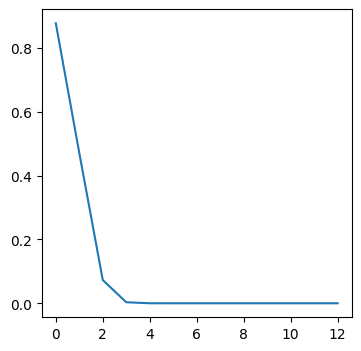

In [6]:
# visualize the initial conditions
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(range(0,L_qpc),qpc_init.real)



In [7]:
# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                          c_list[bond_index+1].dag()*c_list[bond_index] )

H = H_QC + Hdot  + Hint

print(H_QC.isherm, Hdot.isherm, Hint.isherm, H.isherm)

# get the operators needed for lindbladian 
# hrtr we don't really want dephasing but just put it there for now
collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
# add the energy to also track it
expect_ops.append(H)

# for plotting SMALL Hamiltonians
"""fig, ax = hinton(H)
ax.tick_params(axis='both', which='major', labelsize = 7)
ax.tick_params(axis='x', rotation=90)
plt.savefig('H.pdf')"""


True True True True


"fig, ax = hinton(H)\nax.tick_params(axis='both', which='major', labelsize = 7)\nax.tick_params(axis='x', rotation=90)\nplt.savefig('H.pdf')"

In [8]:
times = np.linspace(0.0, max_t, tsteps)
result = sesolve(H, psi0, times, e_ops=expect_ops)

result

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00013113021850585938
    preparation time: 0.02096104621887207
    run time: 1.4752349853515625
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 10.0] (200 steps)
  Number of e_ops: 16
  State not saved.
>

In [9]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 

# save results to hdf5 file
file_name = "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om{}.hdf5".format(L_qpc, max_t, band_width, 
                                                                  K0, J_prime, t, Omega)
param_dict = {"L_qpc": L_qpc, "max_time": max_t,"tsteps": tsteps,"bond_index": bond_index, 
              "band_width": band_width,"g_velocity":K0, "J_prime":J_prime , "t": t, "Omega": Omega }

results_file = h5py.File(data_route+file_name,'w')
# save parameters and maybe other meta data
grp = results_file.create_group("metadata")
grp.create_dataset("parameters", data=json.dumps(param_dict))

# save the quantities that we are interested in 
grp = results_file.create_group("results")
grp.create_dataset("time", data=times)
grp.create_dataset("d1_density", data=result.expect[-3])
grp.create_dataset("d2_density", data=result.expect[-2])
grp.create_dataset("QPC_left_density", data=n_left)
grp.create_dataset("QPC_right_density", data=n_right)
grp.create_dataset("QPC_bond_density", data=n_bond)

results_file.close()


# Densities

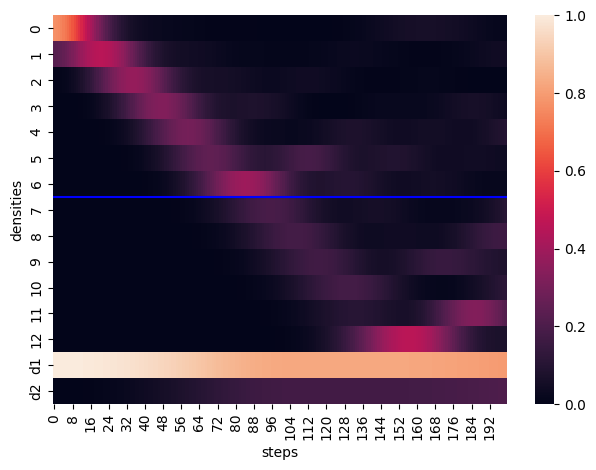

In [10]:

xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")
# location of the bond 
ax.axhline(bond_index+1,c='blue')

site_ticks = list(range(0,L_qpc)) + ["d1","d2"]
tick_pos = np.asarray(range(0,L)) + 0.5

ax.set_yticks(tick_pos,site_ticks);

plt.tight_layout()

plt.savefig("../plots/QPC_double_dot/heatmap_Om={:.2f}_L={:.2f}_tdot={:.2f}_Jp={:.2f}_K={}.png".format(Omega,
                                                    L_qpc, t, J_prime,K0), dpi=400)


Here we can also plot the expecter rabi oscilations for the decoupled case

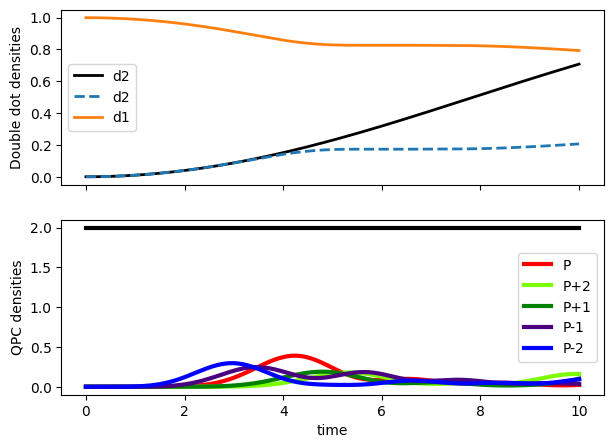

In [11]:
fig, ax = plt.subplots(2,1, figsize=(7,5),sharex=True)
wr = t
rabi_osc = np.sin(wr*times)**2

# in dot
ax[0].plot(times, rabi_osc, linewidth=2.0, alpha=1.0, c='black' ,label="d2")
ax[0].plot(times, result.expect[-2], linewidth=2.0, alpha=1.0, linestyle="dashed" ,label="d2")
ax[0].plot(times, result.expect[-3], linewidth=2.0, alpha=1.0, label="d1")

# in Qpc
#for i in range(0,L_qpc):
#    ax[1].plot(times, result.expect[i], linewidth=2, alpha=0.7)
    
ax[1].plot(times, result.expect[bond_index], linewidth=3,c="red", label="P")
ax[1].plot(times, result.expect[bond_index+2], linewidth=3, c="lawngreen",label="P+2")
ax[1].plot(times, result.expect[bond_index+1], linewidth=3, c="green",label="P+1")
ax[1].plot(times, result.expect[bond_index-1], linewidth=3, c="indigo", label="P-1")
ax[1].plot(times, result.expect[bond_index-2], linewidth=3, c="blue", label="P-2")


# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect[:-1], axis=0)
ax[1].plot(times, n_tot, c='black', linewidth=3.0)

ax[1].set_xlabel("time")
ax[0].set_ylabel("Double dot densities")
ax[1].set_ylabel("QPC densities")
ax[0].legend()
ax[1].legend()

#plt.savefig("../plots/QPC_double_dot/densities_Om={:.2f}_L={:.2f}_tdot={:.2f}_Jp={:.2f}.pdf".format(Omega,
#                                                    L_qpc, t, J_prime))


# Reflection and Transmision

## Compare to Analytic solution for decoupled case

Taken from: https://physics.stackexchange.com/questions/709973/open-boundary-condition-in-hubbard-model

The eigenbasis of the tight binding QPC Hamiltonian with the double dot interaction is in k-space


In [12]:
k_arr = (np.pi/(L_qpc+1))*np.arange(1,L_qpc+1)
Ek_arr = -2*np.cos(k_arr) # eigenenergies
vk_arr = np.zeros((L_qpc, len(k_arr)))# eigenvalues 
# create the eigenvectors:
for k in range(0,len(k_arr)):
    # first index is lattice site second index are k-momenta
    vk = np.sin(k_arr[k]*np.arange(1,L_qpc+1))
    # normalize 
    mag2 = np.dot(vk,vk)
    vk_arr[:,k] = vk/np.sqrt(mag2)

# express the time evolution of the occupation psi in terms of the eigenvectors by changing basis
psi_t = np.zeros((L_qpc, len(times)),dtype=complex) # first index is lattice site, second is time
psi_t[:,0] = qpc_init

# time evolution
for t_index in range(1,len(times)):
    # basis change
    for k_index in range(0,len(k_arr)):
        tt = times[t_index]
        psi_t[:,t_index] += np.dot(qpc_init,vk_arr[:,k_index])*np.exp(-1j*tt*Ek_arr[k_index])*vk_arr[:,k_index]
   
psi_probas = np.abs(psi_t)**2


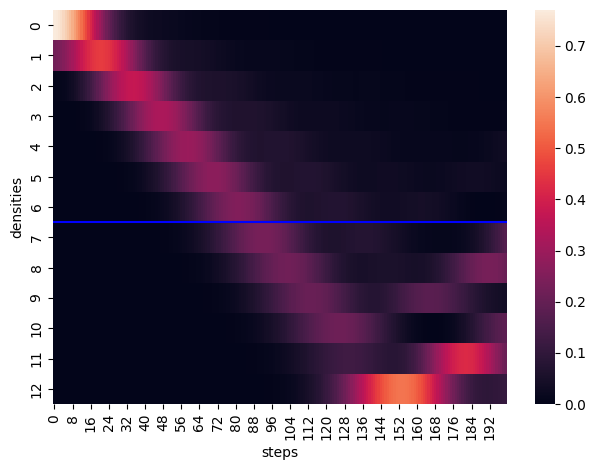

In [13]:
ax = sns.heatmap(psi_probas)
ax.set_xlabel("steps")
ax.set_ylabel("densities")
# location of the bond 
ax.axhline(bond_index+1,c='blue')

site_ticks = list(range(0,L_qpc)) 
tick_pos = np.asarray(range(0,L_qpc)) + 0.5

ax.set_yticks(tick_pos,site_ticks);

plt.tight_layout()


If we want to read and process the raw data do this

In [14]:
"""data_route = "../data/sims/"
file_name = "res_L10_maxtim10_bw0.8_k0.01_jp0.5_t1.0_om0.0.hdf5"

# loading the raw date that has been produced
with h5py.File(data_route+file_name, 'r') as res_h5:
    param_dict = json.loads(res_h5['metadata/parameters'][()])
    print(res_h5["results"].keys())
    n_bond = res_h5["results/QPC_bond_density"][:]
    n_left = res_h5["results/QPC_left_density"][:]
    n_right = res_h5["results/QPC_right_density"][:]
    
res_h5.close()"""

'data_route = "../data/sims/"\nfile_name = "res_L10_maxtim10_bw0.8_k0.01_jp0.5_t1.0_om0.0.hdf5"\n\n# loading the raw date that has been produced\nwith h5py.File(data_route+file_name, \'r\') as res_h5:\n    param_dict = json.loads(res_h5[\'metadata/parameters\'][()])\n    print(res_h5["results"].keys())\n    n_bond = res_h5["results/QPC_bond_density"][:]\n    n_left = res_h5["results/QPC_left_density"][:]\n    n_right = res_h5["results/QPC_right_density"][:]\n    \nres_h5.close()'

Text(0, 0.5, '$\\text{Analytical } \\psi(t) $')

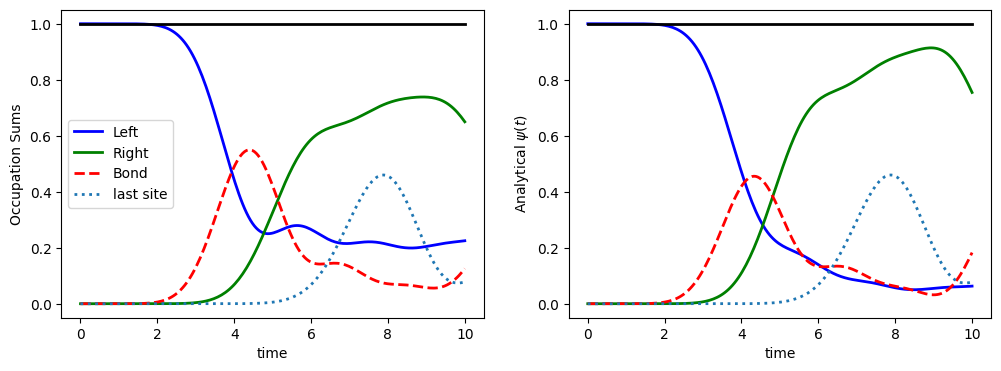

In [15]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[0].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[0].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[0].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[0].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[0].set_xlabel("time")
ax[0].set_ylabel("Occupation Sums")
ax[0].legend()

# now we do the same but for the analytical results

n_left = np.sum(psi_probas[:bond_index,:], axis=0)
n_right = np.sum(psi_probas[bond_index+2:,:], axis=0)
n_bond = psi_probas[bond_index,:] + psi_probas[bond_index+1,:] 

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[1].set_xlabel("time")
ax[1].set_ylabel(r"$\text{Analytical } \psi(t) $")


Text(0, 0.5, 'Energy')

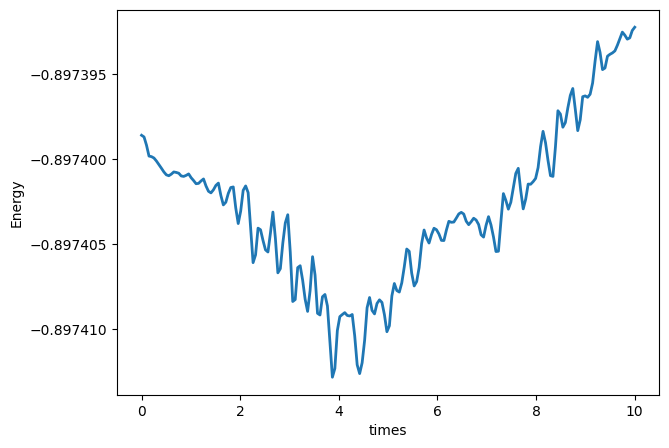

In [16]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")
